  ## Single split testing workflow


  ### Installation

  <pre>pip install pandas pingouin seaborn matplotlib sklearn</pre>

  We need the development version of scikit-posthocs to get critical difference diagrams

  <pre>pip install git+https://github.com/maximtrp/scikit-posthocs.git</pre>



In [62]:
import matplotlib.pyplot as plt
import pandas as pd
import pingouin as pg
import scikit_posthocs as sp
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, precision_score, recall_score, confusion_matrix
from statsmodels.stats.multicomp import MultiComparison
from collections import defaultdict
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from statsmodels.stats.anova import AnovaRM
from scipy.stats import levene

Global variables

In [63]:
metric_ls = ["abs_resid", "sq_resid"]
thresh = -4

  A few utility functions to make life easier

In [64]:
def calc_regression_metrics(df_in, cycle_col, val_col, pred_col):
    """
    Calculate regression metrics (MAE, MSE, R2, prec, recall) for each method and split
    :param df_in: input dataframe must contain columns [method, split] as well the columns specified in the arguments
    :param cycle_col: column indicating the cross-validation fold
    :param val_col: column with the ground truth value
    :param pred_col: column with predictions
    :return: a dataframe with [cv_cycle, method, split, mae, mse, r2, prec, recall]
    """
    metric_list = []
    for k, v in df_in.groupby([cycle_col, "method", "split"]):
        cycle, method, split = k
        mae = mean_absolute_error(v[val_col], v[pred_col])
        mse = mean_squared_error(v[val_col], v[pred_col])
        r2 = r2_score(v[val_col], v[pred_col])
        recall = recall_score(v[val_col] > thresh, v[pred_col] > thresh)
        prec = precision_score(v[val_col] > thresh, v[pred_col] > thresh)
        # recall, _ = recall_at_precision(v[val_col] > thresh, v[pred_col], 0.8)
        # tnr, _ = tnr_at_recall(v[val_col] > thresh, v[pred_col], 0.9)
        metric_list.append([cycle, method, split, mae, mse, r2, prec, recall])
    metric_df = pd.DataFrame(metric_list, columns=["cv_cycle", "method", "split"] + metric_ls)
    return metric_df

def make_boxplots_one_split_parametric(df):
    """
    Plot box plots showing comparisons of [mae, mse, r2, prec, recall], p-value for Friedman's test is shown as the plot title
    :param df: input dataframe, must contain [cv_cycle, method, mae, mse, r2, prec, recall]
    """
    sns.set_context('notebook')
    sns.set(rc={'figure.figsize': (4, 3)}, font_scale=1.5)
    sns.set_style('whitegrid')
    # figure, axes = plt.subplots(1, 5, sharex=False, sharey=False, figsize=(26, 8))
    figure, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(16, 8))

    for i, stat in enumerate(metric_ls):
        model = AnovaRM(data=df, depvar=stat, subject='Name', within=['method']).fit()
        p_value = model.anova_table['Pr > F'].iloc[0]
        ax = sns.boxplot(y=stat, x="method", hue="method", ax=axes[i], data=df, palette="Set2", legend=False)
        title = stat.upper()
        ax.set_title(f"p={p_value:.03f}")
        ax.set_xlabel("")
        ax.set_ylabel(title)
    plt.tight_layout()

def make_boxplots_one_split_nonparametric(df):
    """
    Plot box plots showing comparisons of [roc_auc, pr_auc, mcc], p-value for Friedman's test is shown as the plot title
    :param df: input dataframe, must contain [cv_cycle, method, roc_auc, pr_auc, mcc]
    """
    sns.set_context('notebook')
    sns.set(rc={'figure.figsize': (4, 3)}, font_scale=1.5)
    sns.set_style('whitegrid')
    figure, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(16, 8))
    # figure, axes = plt.subplots(1, 5, sharex=False, sharey=False, figsize=(26, 8))

    for i, stat in enumerate(metric_ls):
        friedman = pg.friedman(df, dv=stat, within="method", subject="Name")['p-unc'].values[0]
        ax = sns.boxplot(y=stat, x="method", hue="method", ax=axes[i], data=df, palette="Set2", legend=False)
        title = stat.replace("_", " ").upper()
        ax.set_title(f"p={friedman:.03f}")
        ax.set_xlabel("")
        ax.set_ylabel(title)
        # ax.set_ylim(0, 1)
    plt.tight_layout()

def make_sign_plots_one_split_parametric(df):
    """
    Plot sign plots showing statistical significance of comparisons of [mae, mse, r2, prec, recall]
    :param df: input dataframe, must contain [method, cv_cycle, mae, mse, r2, prec, recall]
    """
    heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': True, 'square': True}
    sns.set(rc={'figure.figsize': (4, 3)}, font_scale=1.5)
    figure, axes = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(16, 8))
    # figure, axes = plt.subplots(1, 5, sharex=False, sharey=True, figsize=(26, 8))

    for i, stat in enumerate(metric_ls):
        pc = sp.posthoc_tukey(df, val_col=stat, group_col="method")
        sub_ax, sub_c = sp.sign_plot(pc, **heatmap_args, ax=axes[i], xticklabels=True)  # Update xticklabels parameter
        sub_ax.set_title(stat.upper())

def make_sign_plots_one_split_nonparametric(df):
    """
    Plot sign plots showing statistical significance of comparisons of [mae, mse, r2, recall, tnr]
    :param df: input dataframe, must contain [method, cv_cycle, mae, mse, r2, recall, tnr]
    """
    heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': True, 'square': True}
    sns.set(rc={'figure.figsize': (4, 3)}, font_scale=1.5)
    # figure, axes = plt.subplots(1, 5, sharex=False, sharey=True, figsize=(26, 8))
    figure, axes = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(16, 8))

    for i, stat in enumerate(metric_ls):
        pc = sp.posthoc_conover_friedman(df, y_col=stat, group_col="method", block_col="Name", p_adjust="holm",
                                         melted=True)
        sub_ax, sub_c = sp.sign_plot(pc, **heatmap_args, ax=axes[i], xticklabels=True)  # Update xticklabels parameter
        sub_ax.set_title(stat.upper())


def make_mean_ci_plot(df, metric, group_col, xlabel = "metric", ax = None, figsize=(8, 4), title = ""):
    df_means = df.groupby(group_col).mean(numeric_only=True).sort_values(metric, ascending=True)
    df_sorted = df.set_index(group_col).loc[df_means.index].reset_index()
    mc = MultiComparison(df_sorted[metric], df_sorted[group_col], group_order=df_means.index)
    results = mc.tukeyhsd()
    if ax is None:
        plot = results.plot_simultaneous(xlabel=xlabel, figsize=figsize)
    else:
        plot = results.plot_simultaneous(ax=ax, xlabel=xlabel, figsize=figsize)
    # plot.get_axes()[0].title.set_text(title)

def make_mean_ci_plot_grid(df, metrics, metric_names, group_col, figsize):
    fig, ax = plt.subplots(len(metrics), 1, figsize=figsize) 
    for i, metric in enumerate(metrics):
        make_mean_ci_plot(df, metric=metric, group_col=group_col,
                           xlabel="", ax=ax[i], figsize=figsize, title="")
    plt.tight_layout()
    for i, a in enumerate(ax):
        a.title.set_text(metric_names[i].upper())

def make_mean_diff_ci_plot(df, metric, xlabel, group_col, ax=None, figsize=(8, 4), title = ""):
    df_means = df.groupby(group_col).mean(numeric_only=True).sort_values(metric, ascending=False)
    df_sorted = df.set_index(group_col).loc[df_means.index].reset_index()
    mc = MultiComparison(df_sorted[metric], df_sorted[group_col], group_order=df_means.index)
    results = mc.tukeyhsd()
    result_tab = results.summary().data
    columns = result_tab.pop(0)
    result_tab = pd.DataFrame(result_tab, columns=columns)
    result_tab[["meandiff", "lower", "upper"]] = result_tab[["meandiff", "lower", "upper"]] * -1
    result_tab.rename(columns={"lower": "upper", "upper": "lower"}, inplace=True)
    result_tab["group1_mean"] = result_tab["group1"].map(df_means[metric])
    result_tab["group2_mean"] = result_tab["group2"].map(df_means[metric])

    # result_tab.index = result_tab['group1'] + ' - ' + result_tab['group2'] + \
    #                     '\n' + '(' + result_tab["group1_mean"].map("{:.2f}".format) + \
    #                     ' - ' + result_tab["group2_mean"].map("{:.2f}".format) + ')'
    
    result_tab.index = result_tab['group1'] + ' - ' + result_tab['group2']

    result_err = np.array([result_tab['meandiff'] - result_tab['lower'],
                            result_tab['upper'] - result_tab['meandiff']])
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    ax.errorbar(y=result_tab.index, x=result_tab['meandiff'], xerr=result_err,
                 fmt='o', capsize=5)
    ax.axvline(x=0, color='black', linestyle='--')
    ax.invert_yaxis()
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    
    if ax is None:
        plt.show()

def make_mean_diff_ci_plot_grid(df, metrics, metric_names, group_col, figsize):
    fig, ax = plt.subplots(len(metrics), figsize=figsize) 
    for i, metric in enumerate(metrics):
        if i == 0:
            title = 'Multiple Comparison of Means - Tukey HSD, FWER=0.05'
        else:
            title = ""

        make_mean_diff_ci_plot(df, metric=metric, group_col=group_col,
                           xlabel=metric_names[i], ax=ax[i], figsize=figsize, title=title)
    plt.tight_layout()
    
def make_critical_difference_diagrams_one_split(df):
    """
    Plot critical difference diagrams showing statistical significance of comparisons of [mae, mse, r2, recall, tnr]
    :param df: input dataframe, must contain [method, cv_cycle, mae, mse, r2, recall, tnr]
    """
    # figure, axes = plt.subplots(5, 1, sharex=True, sharey=False, figsize=(16, 8))
    figure, axes = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(16, 8))
    for i, stat in enumerate(metric_ls):
        avg_rank = df.groupby("cv_cycle")[stat].rank(pct=True).groupby(df.method).mean()
        pc = sp.posthoc_conover_friedman(df, y_col=stat, group_col="method", block_col="Name", p_adjust="holm",
                                         melted=True)
        sp.critical_difference_diagram(avg_rank, pc, ax=axes[i])
        axes[i].set_title(stat.upper())
    plt.tight_layout()


def generate_scaffold(mol, include_chirality=True):
    """
    Compute the Bemis-Murcko scaffold for a SMILES string.
    Implementation copied from https://github.com/chemprop/chemprop.

    :param mol: A smiles string or an RDKit molecule.
    :param include_chirality: Whether to include chirality.
    :return:
    """
    mol = Chem.MolFromSmiles(mol) if type(mol) == str else mol
    scaffold = MurckoScaffold.MurckoScaffoldSmiles(mol=mol, includeChirality=include_chirality)

    return scaffold

def scaffold_to_smiles(mols, use_indices):
    """
    Computes scaffold for each smiles string and returns a mapping from scaffolds to sets of smiles.
    Implementation copied from https://github.com/chemprop/chemprop.

    :param mols: A list of smiles strings or RDKit molecules.
    :param use_indices: Whether to map to the smiles' index in all_smiles rather than mapping
    to the smiles string itself. This is necessary if there are duplicate smiles.
    :return: A dictionary mapping each unique scaffold to all smiles (or smiles indices) which have that scaffold.
    """
    scaffolds = defaultdict(set)
    for i, mol in enumerate(mols):
        scaffold = generate_scaffold(mol)
        if use_indices:
            scaffolds[scaffold].add(i)
        else:
            scaffolds[scaffold].add(mol)

    return scaffolds


In [65]:
from matplotlib import colors
from matplotlib.colorbar import ColorbarBase


def mcs_plot(pc, effect_size, means, labels=True, cmap=None, cbar_ax_bbox=None, 
             ax=None, show_diff=True, cell_text_size=16, axis_text_size = 12, 
             show_cbar=False, reverse_cmap=False, **kwargs):
    pc_copy = pc.copy()
    
    for key in ['cbar', 'vmin', 'vmax', 'center']:
        if key in kwargs:
            del kwargs[key]

    if not cmap:
        cmap = "coolwarm"
    if reverse_cmap:
        cmap = cmap + "_r"


    significance = pc_copy.astype(object)
    significance[(pc < 0.001) & (pc >= 0)] = '***'
    significance[(pc < 0.01) & (pc >= 0.001)] = '**'
    significance[(pc < 0.05) & (pc >= 0.01)] = '*'
    significance[(pc >= 0.05)] = ''

    np.fill_diagonal(significance.values, '')

    # Create a DataFrame for the annotations
    if show_diff:
        annotations = effect_size.round(3).astype(str) + significance
    else:
        annotations = significance

    hax = sns.heatmap(effect_size, cmap=cmap, annot=annotations, fmt='', cbar=False, ax=ax,
                       annot_kws={"size": cell_text_size}, **kwargs)
    
    if labels:
        hax.set_xticklabels([f'{label.get_text()}\n{means.loc[label.get_text()].round(2)}' for label in hax.get_xticklabels()],
                            size=axis_text_size, ha='center', va='top', rotation=0, rotation_mode='anchor')
        yticklabels = [f'\n{label.get_text()}\n{means.loc[label.get_text()].round(2)}\n\n' for label in hax.get_yticklabels()]
        hax.set_yticklabels(yticklabels, size=axis_text_size, ha='center', va='center', rotation=90, rotation_mode='anchor')
    else:
        hax.set_xlabel('')
        hax.set_ylabel('')

    hax.set_xlabel('')
    hax.set_ylabel('')

    if show_cbar:
        cbar_ax = hax.figure.add_axes(cbar_ax_bbox or [0.95, 0.35, 0.04, 0.3])
        cbar = ColorbarBase(cbar_ax, cmap=cmap, norm=colors.Normalize(vmin=effect_size.min().min(), vmax=effect_size.max().max()))
        cbar.outline.set_linewidth(1)
        cbar.outline.set_edgecolor('0.5')
        cbar.ax.tick_params(size=0)
    else:
        cbar = None

    return hax, cbar

def make_mcs_plot_grid(df, stats, figsize=(20, 10), direction_dict=None,
                       cell_text_size=16, axis_text_size=12, title_text_size=16):
    fig, ax = plt.subplots(2, 3, figsize=figsize) 
    for i, stat in enumerate(stats):
        row = i // 3
        col = i % 3
        pc = sp.posthoc_tukey(df, val_col=stat, group_col="method")
        pc = pd.DataFrame(pc)
        
        # Sort df_means in ascending or descending order based on the direction_dict
        reverse_cmap = False
        if direction_dict and stat in direction_dict:
            if direction_dict[stat] == 'maximize':
                df_means = df.groupby("method").mean(numeric_only=True).sort_values(stat, ascending=False)[stat]
            elif direction_dict[stat] == 'minimize':
                df_means = df.groupby("method").mean(numeric_only=True).sort_values(stat, ascending=True)[stat]
                reverse_cmap = True
            else:
                raise ValueError("Invalid direction. Expected 'maximize' or 'minimize'.")
        else:
            df_means = df.groupby("method").mean(numeric_only=True)[stat]
        # Reindex pc to match the order of df_means
        pc = pc.reindex(df_means.index).reindex(df_means.index, axis=1)

        df_means_diff = pd.DataFrame(index=df_means.index, columns=df_means.index)

        for method1 in df_means.index:
            for method2 in df_means.index:
                if method1 == method2:
                    df_means_diff.loc[method1, method2] = 0
                else:
                    diff = df_means.loc[method1] - df_means.loc[method2]
                    df_means_diff.loc[method1, method2] = diff

        df_means_diff = df_means_diff.astype(float)
        hax, cbar = mcs_plot(pc, effect_size=df_means_diff, means=df_means,
                                   show_diff=True, ax=ax[row, col], cbar=True, 
                                   cell_text_size=cell_text_size, axis_text_size=axis_text_size,
                                   reverse_cmap=reverse_cmap)
        hax.set_title(stat.upper(), fontsize=title_text_size)

    # If there are less plots than cells in the grid, hide the remaining cells
    if len(stats) < 6:
        for i in range(len(stats), 6):
            row = i // 3
            col = i % 3
            ax[row, col].set_visible(False)

    plt.tight_layout()


  ## 1. Read in data


In [66]:
df_input = pd.read_csv("Sol_regression_ChemProp_LightGBM.csv")
df_input = df_input[df_input["cv_cycle"] == 0] # Extract only one split
df_input.head()

,cv_cycle,split,method,SMILES,Name,Sol,Sol_pred
0,0,random,chemprop_st,COc1ccc2c(-c3ccccc3)cc3nnnn3c2c1,Mol3209,-0.265288,-0.087873
1,0,random,chemprop_st,Cc1ccc(CNC(=O)CN2CCC(n3nnc4cc(C)ccc43)CC2)cc1,Mol647,1.902668,1.878704
2,0,random,chemprop_st,CCc1nc(CN2C(=O)COc3ccc(F)cc32)cs1,Mol995,1.854473,2.098663
3,0,random,chemprop_st,CCOC(C)C(=O)N1CCC(n2c(=O)[nH]c3ccccc32)CC1,Mol1707,2.308977,2.237075
4,0,random,chemprop_st,Cc1cc(F)ccc1NC(=O)c1cccc2cccnc12,Mol3142,0.195826,1.190098


In [67]:
# Solubilty was in log micromolar, adjust to log molar
df_input["Sol"] = df_input["Sol"] - 6
df_input["Sol_pred"] = df_input["Sol_pred"] - 6

  ## 2. Calculate Regression Metrics

In [68]:
df_input["residual"] = df_input.Sol - df_input.Sol_pred
df_input["abs_resid"] = df_input["residual"]**2
df_input["sq_resid"] = df_input["residual"].abs()

To better satisfy the IID assumption, we take one representative from each scaffold to ensure the there are not close analogues in the data.

In [69]:
df_input = df_input.query("split == 'scaffold'").copy()

df_input_filt = pd.DataFrame()
for k, v in df_input.groupby(["cv_cycle", "split", "method"]):
    cycle, split, method = k
    indices = scaffold_to_smiles(v.SMILES, use_indices=True)
    indices = {k: list(v)[0] for k, v in indices.items()}
    v.reset_index(drop=True, inplace=True)
    df_input_filt = pd.concat([df_input_filt, v.loc[list(indices.values())]])
df_input_filt


df_scaffold_split = df_input_filt.copy()

## 3. Examining the parametric testing assumptions

Plot the distribution of the absolute residuals and the squared residuals, which will be used to test for a difference of MAE and MSE.  Clearly the distributions are not normal, but since the sample sizes are above a few hundred, we will likely have a valid test even with this strong violation of normality. See [here](https://www.researchgate.net/publication/11454445_The_Importance_of_the_Normality_Assumption_in_Large_Public_Health_Data_Sets) for details.

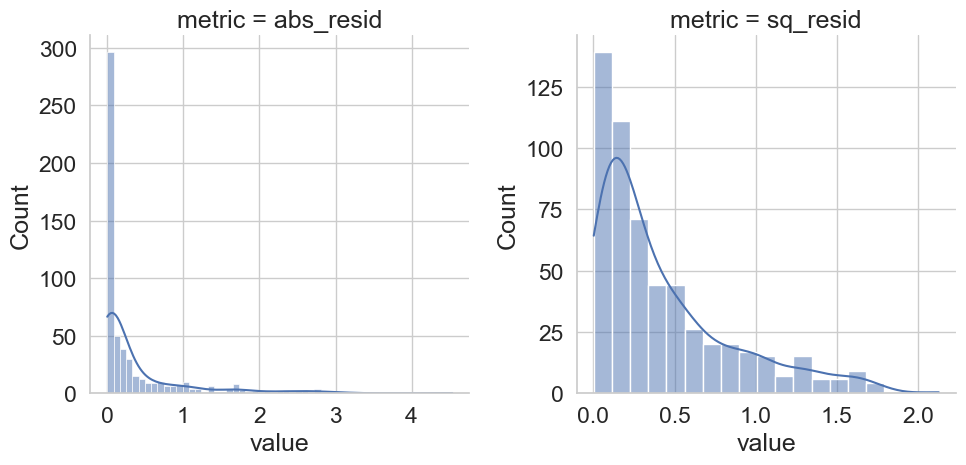

In [70]:
df_scaffold_split_norm = df_scaffold_split.copy()
df_scaffold_split_stacked_norm = df_scaffold_split_norm.melt(id_vars=["cv_cycle", "method", "split"],
                                               value_vars=metric_ls,
                                               var_name="metric",
                                               value_name="value")

def plot_facetgrid(df):
#     sns.set_context('notebook', font_scale=1.5)  # Increase font scale
    sns.set_style('whitegrid')
    figure = sns.FacetGrid(df, col="metric", sharex=False, sharey=False, height=5, aspect=1)
    figure.map_dataframe(sns.histplot, x="value", kde=True)
    plt.tight_layout()

plot_facetgrid(df_scaffold_split_stacked_norm)

In [71]:
for metric in metric_ls:
    groups = df_scaffold_split.groupby('method')[metric].apply(list)
    stat, pvalue = levene(*groups)
    print(f'Levene test for {metric}: p-value = {pvalue}')

Levene test for abs_resid: p-value = 0.5328709397942952
Levene test for sq_resid: p-value = 0.8173757756871045


In [72]:
variances_by_method = df_scaffold_split.groupby('method')[metric_ls].var()
max_fold_diff = variances_by_method.max() / variances_by_method.min()
print(max_fold_diff)

abs_resid    1.528718
sq_resid     1.179908
dtype: float64


## 4. Parametric worfklow

### 4.1 Perform repeated measures ANOVA

Since the assumptions were not violated, we proceed through the parametric testing workflow. We start with a test for whether there is any difference between groups. Since the methods are using the same splits, there is dependency in the samples. We account for this using a repeated measures ANOVA.

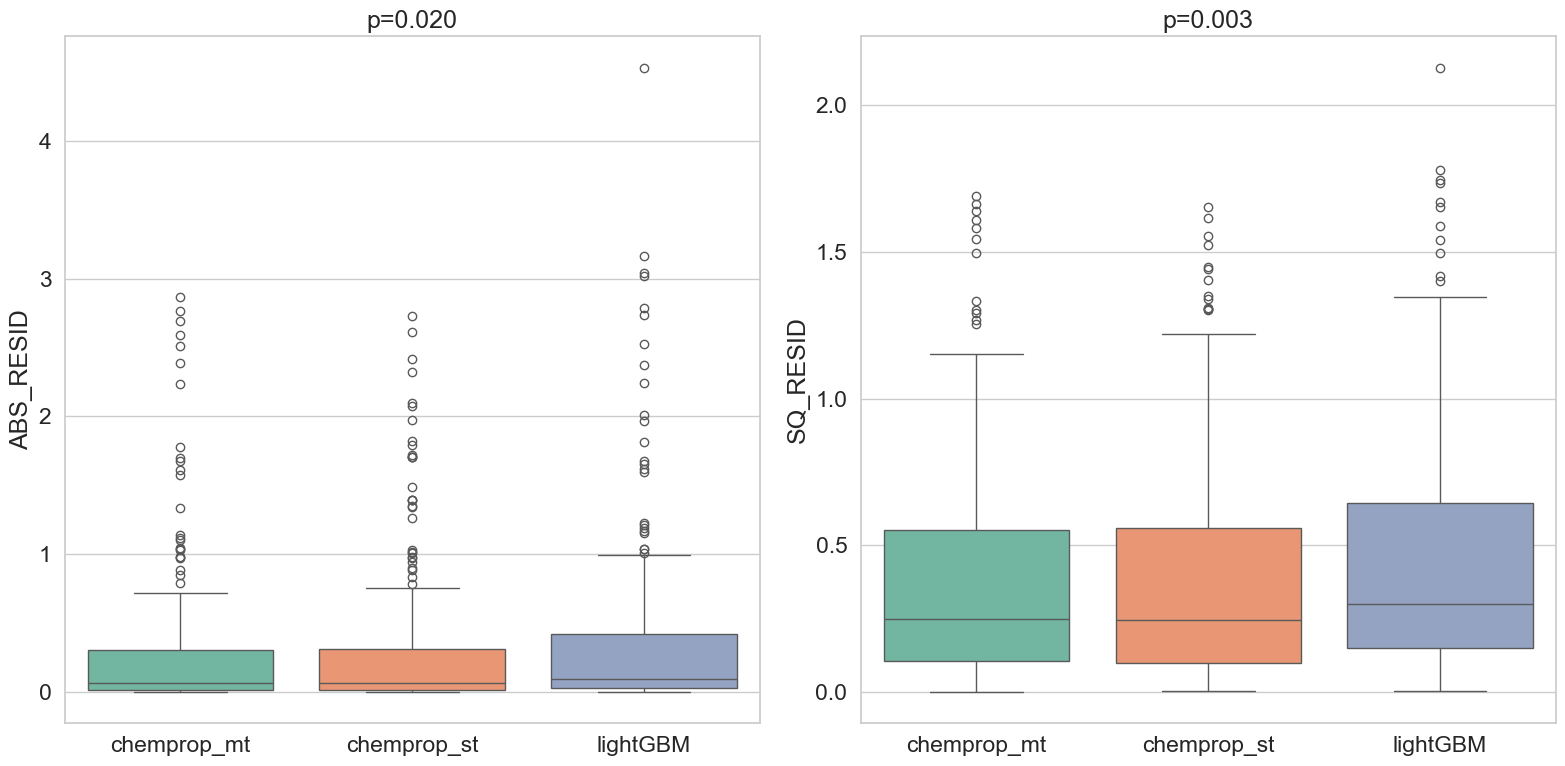

In [73]:
make_boxplots_one_split_parametric(df_scaffold_split)

  ### 4.2 Perform a Post-Hoc Analysis to Examine Differences Between Methods

  The ANOVA test tells us **if** there is difference between three or more distributions, but it doesn't tell us **where** the difference is.  We can use post-hoc tests to look at individual differences.  Note that the p-value for the individual comparisons is corrected to account for multiple compararions. In this case we'll use Tukey's Honestly Significant Difference (HSD).

  #### 4.2.1 Sign Plots

scikit-posthocs and statmodels provide a couple of useful plots for visualizing the results of post-hoc tests.  The first is the sign plot.  This shows the p-value matrices color coded by statistical significance.  Each cell in the plot shows the corrected p-value for one pairwise comparison.  

Interestingly there is no significant difference found between methods in the Tukey HSD post hocs. 

TODO consider changing the color scale. It looks there are large differences when there are not. Perhaps should not use min and max for the scale.  Or we could color by statistical significance as in the old sign plots to avoid this complication.

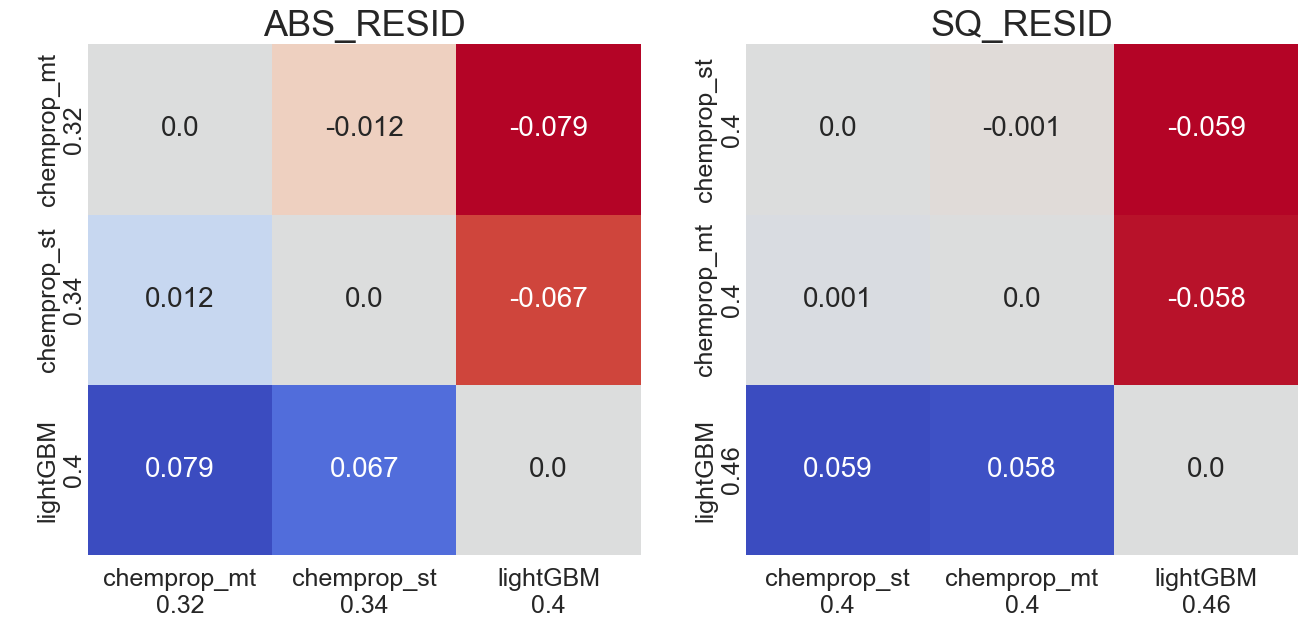

In [74]:
direction_dict = {'abs_resid': 'minimize', 'sq_resid': 'minimize'}
make_mcs_plot_grid(df_scaffold_split, metric_ls, direction_dict=direction_dict,
                   figsize=(20, 12), cell_text_size=20, axis_text_size=18,
                   title_text_size=26)

  #### 4.2.2 Mean performance confidence intervals

Statsmodels provides a useful [visualization tool](https://www.statsmodels.org/dev/generated/statsmodels.sandbox.stats.multicomp.TukeyHSDResults.plot_simultaneous.html) which allows you to compare many methods concisely. 
The confidence intervals are adjusted so that non overlap of confidence intervals corresponds to a statistical test, adjusted for multicomparisons by Tukey HSD.  Intervals that do not overlap imply statistical significance.


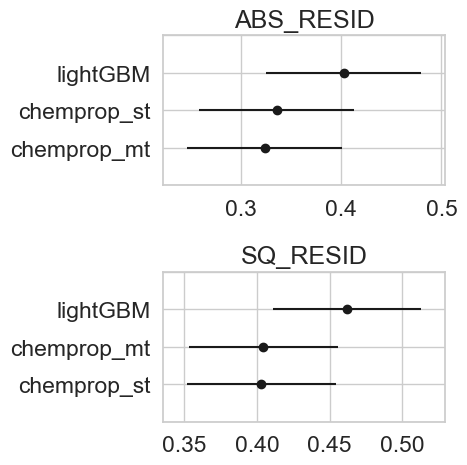

In [75]:
make_mean_ci_plot_grid(df_scaffold_split, metrics=metric_ls,
                       metric_names = metric_ls, group_col="method",
                       figsize=(5, 5))

#### 4.2.3 Difference confidence intervals

The clearest way of visualizing the differences in performance is to plot the pairwise difference between methods.  You can use TukeyHSD to construct confidence intervals for the differences such that uncertainty in the difference estimate is accounted for. Intervals that do not cross the zero line imply statistical significance.



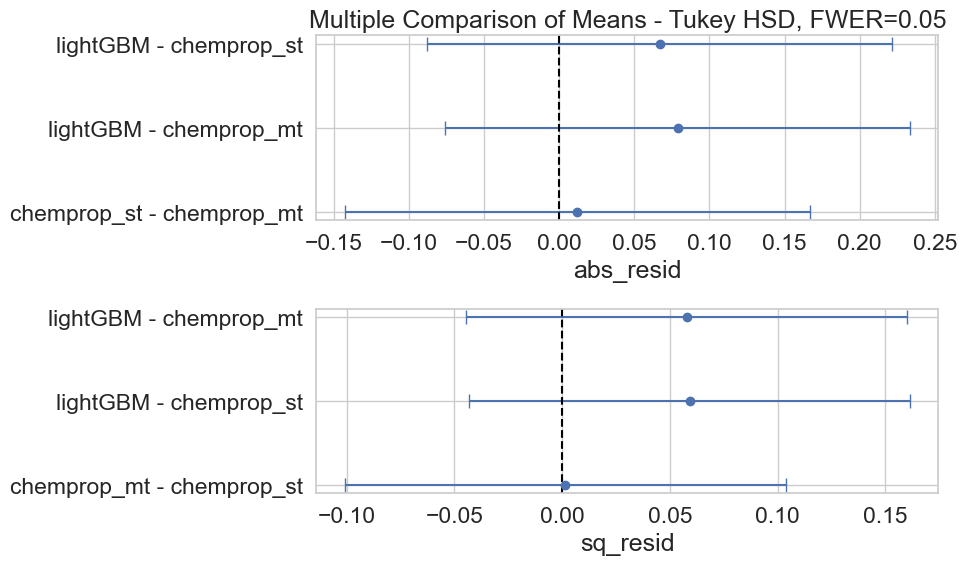

In [76]:
make_mean_diff_ci_plot_grid(df_scaffold_split, metrics=metric_ls, 
                            metric_names = metric_ls,
                            group_col="method", figsize=(10, 6))

  ## 5. Non-parametric workflow

### 5.1 Perform Friedman test


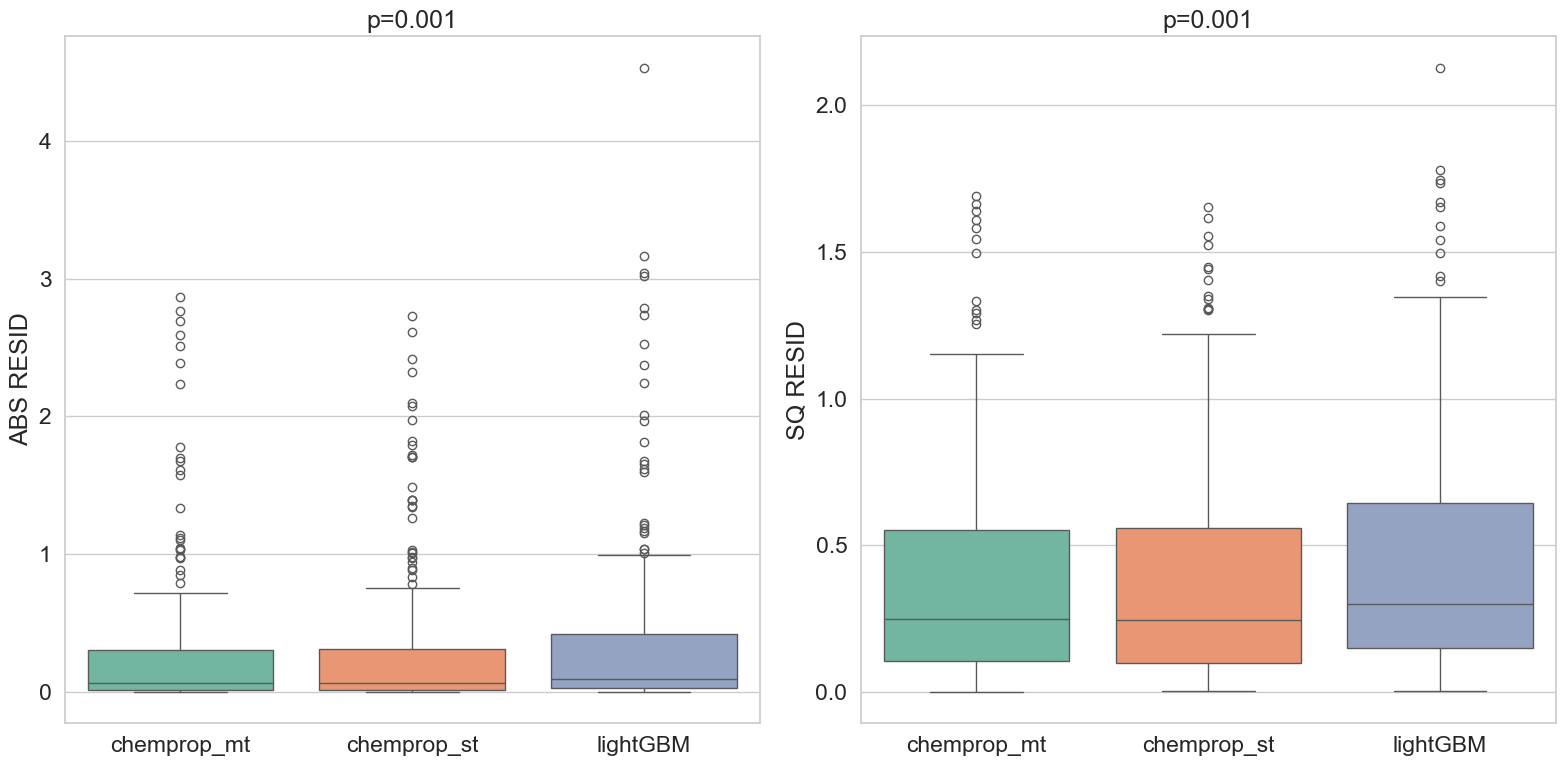

In [77]:
make_boxplots_one_split_nonparametric(df_scaffold_split)


  ### 5.2 Perform a Post-Hoc Analysis to Examine Differences Between Methods

  Friedman's test tells us **if** there is difference between three or more distributions, but it doesn't tell us **where** the difference is.  We can use post-hoc tests to look at inidividual differences.  Note that the p-value for the individual comparisons is corrected to account for multiple compararions. In this case we'll use the [Holm Bonferroni Method](https://en.wikipedia.org/wiki/Holm%E2%80%93Bonferroni_method#:~:text=In%20statistics%2C%20the%20Holm%E2%80%93Bonferroni,powerful%20than%20the%20Bonferroni%20correction). 

#### 5.2.1 Sign Plots
Fortunately, scikit-posthocs provides a couple of useful plots for visualizing the results of post-hoc tests.  The first is the sign plot.  This shows the matrices above color coded by statistical significance.  Each cell in the plot shows the corrected p-value for one pairwise comparison.

There are significant differences in the post hocs using the non parametric worflow but not the parametric.  The non parametric results are likely more reliable here since there is a strong violation of normality in the residuals. The parametric workflow appears to have lower power because of the assumption violation.  An elevated type I error rate would be more of a concern as it would lead to false positives.

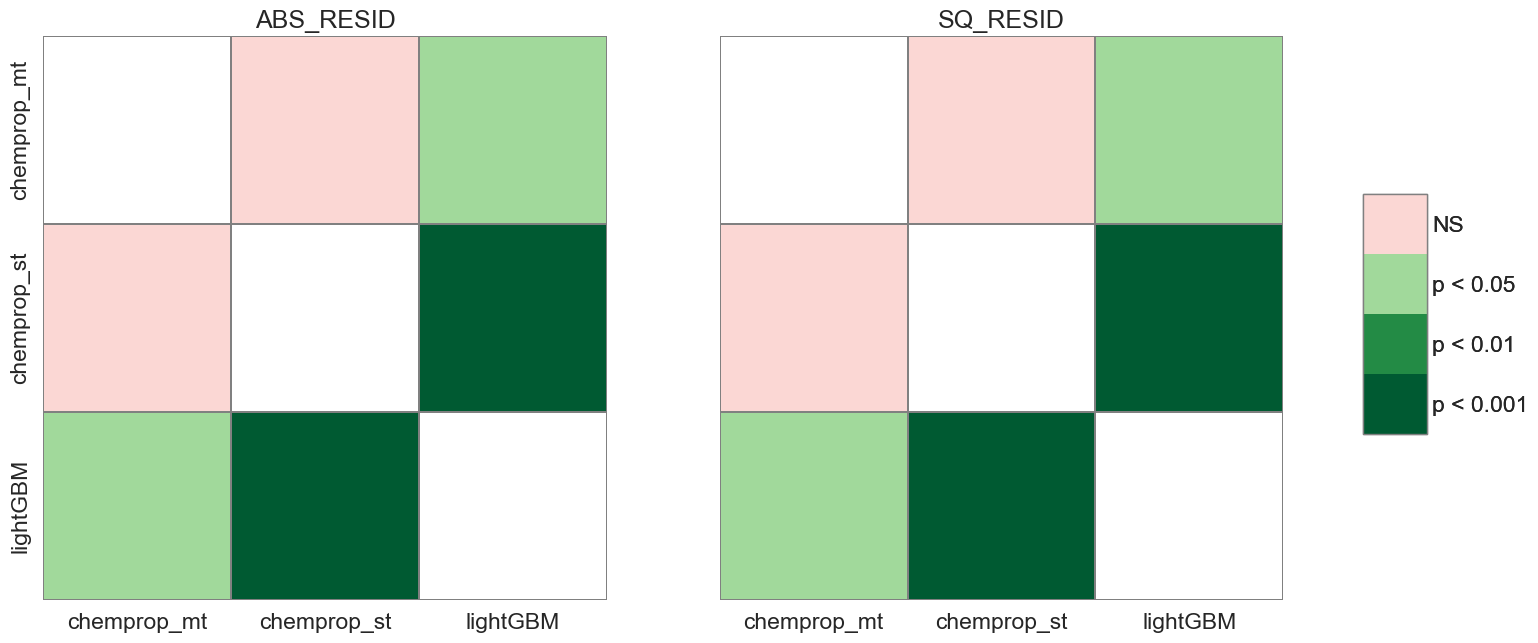

In [78]:
make_sign_plots_one_split_nonparametric(df_scaffold_split)

#### 5.2.2 Critical Difference Diagrams

Another interesting visualization provoided by scikit-posthocs is the [critical difference diagram](https://mirkobunse.github.io/CriticalDifferenceDiagrams.jl/dev/#Reading-a-CD-diagram) (CDD).  In this plot, the methods are ordered by their average ranks.  If two methods are connected by a horizontal line, there is **not** a statistically significant difference between the methods.  One advantage of the CDD over the sign plot is that the CDD aslo shows the ranks of the methods.

c:\Users\Jash4\AppData\Local\anaconda3\envs\chemprop_python3.9\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
c:\Users\Jash4\AppData\Local\anaconda3\envs\chemprop_python3.9\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


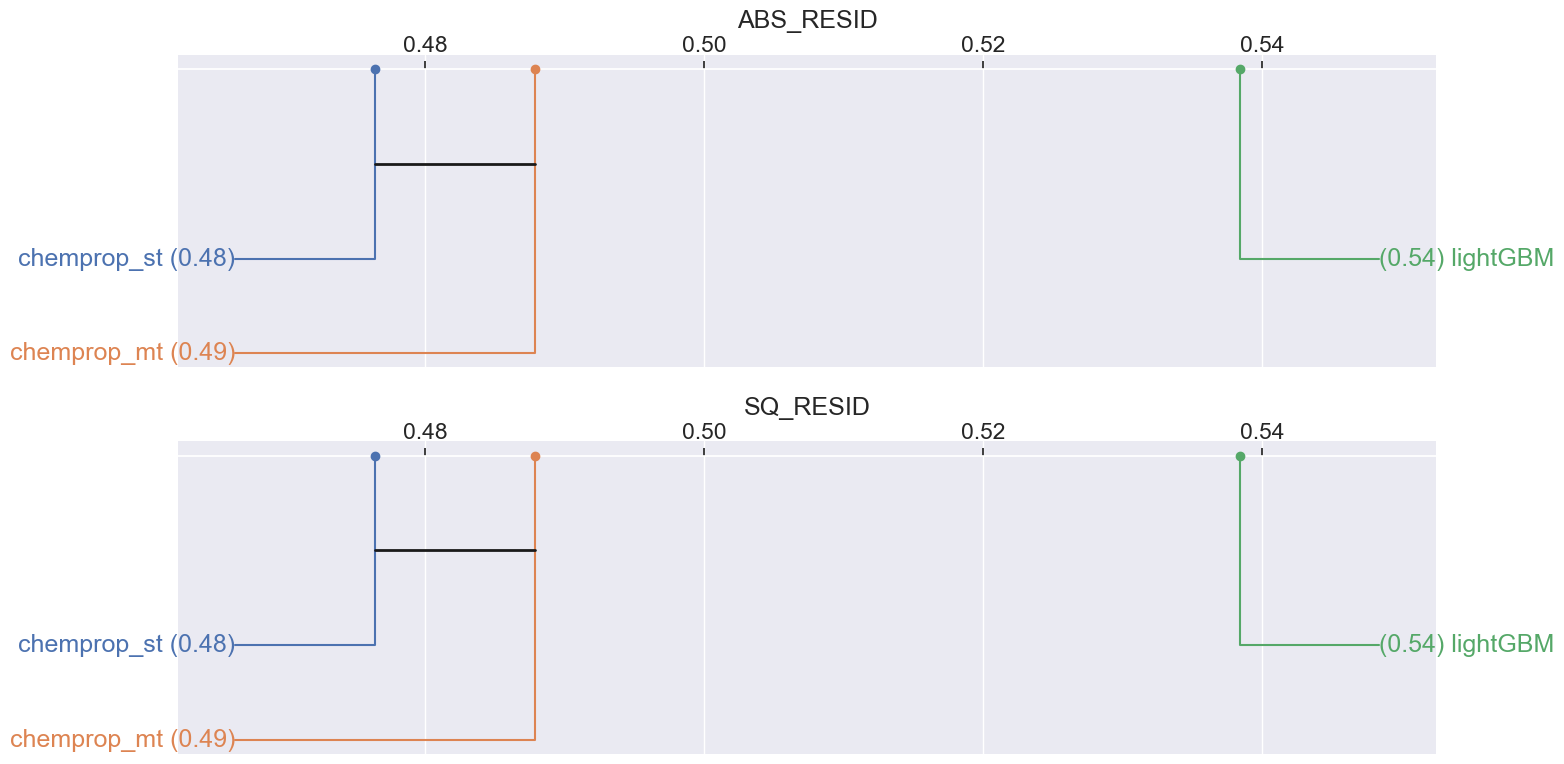

In [79]:
make_critical_difference_diagrams_one_split(df_scaffold_split)